In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),               # Reescalamos las imágenes a 256x256 píxeles
    transforms.CenterCrop(224),           # Recortamos las imágenes a 224x224 píxeles centradas
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.5, hue=0.5),  # Aumento de datos de color
    transforms.ToTensor(),                # Convertimos las imágenes a tensores
    transforms.Normalize(                 # Normalizamos las imágenes con media y desviación estándar predefinidas
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [3]:
train_data = datasets.ImageFolder(root='C:/Users/asus/Documents/Archivos/Fusemachines microdegree/Proyecto final/Data/Data final/Train 4 classes', transform=transform)
test_data = datasets.ImageFolder(root='C:/Users/asus/Documents/Archivos/Fusemachines microdegree/Proyecto final/Data/Data final/Test 4 classes', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

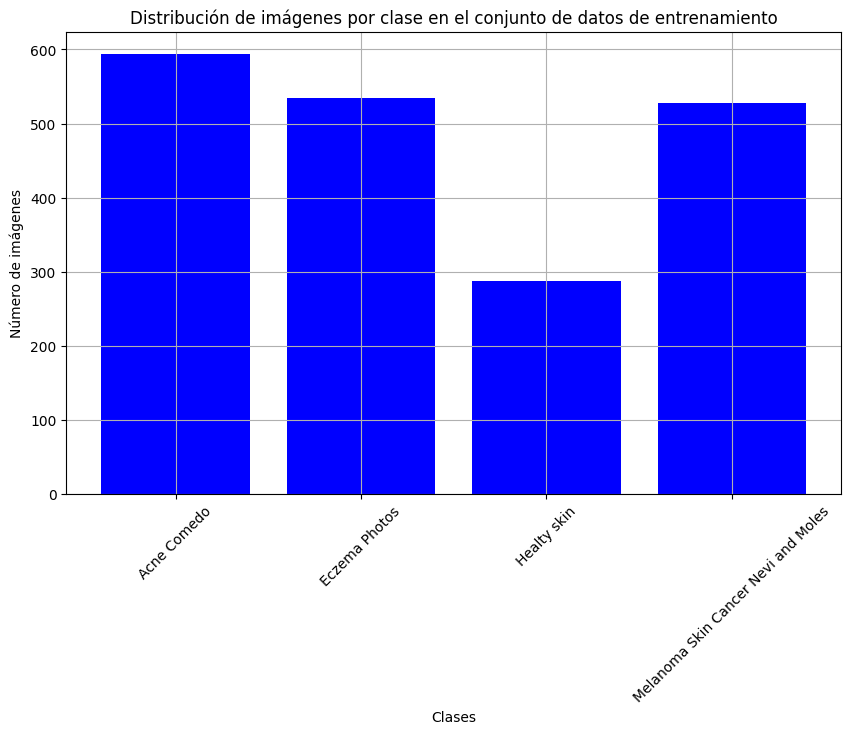

In [4]:


train_path= 'C:/Users/asus/Documents/Archivos/Fusemachines microdegree/Proyecto final/Data/Train 4 classes'
# Obtener la lista de clases (nombres de las carpetas en tu directorio de datos)
classes = os.listdir(train_path)

# Inicializar un diccionario para contar el número de imágenes en cada clase
class_counts = {c: 0 for c in classes}

# Iterar sobre el conjunto de datos de entrenamiento y contar el número de imágenes en cada clase
for root, dirs, files in os.walk(train_path):
    for d in dirs:
        class_counts[d] = len(os.listdir(os.path.join(root, d)))

# Convertir el diccionario en listas separadas de clases y conteos
class_names = list(class_counts.keys())
counts = list(class_counts.values())

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='blue')

# Añadir etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Número de imágenes')
plt.title('Distribución de imágenes por clase en el conjunto de datos de entrenamiento')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.grid(True)

# Mostrar el histograma
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


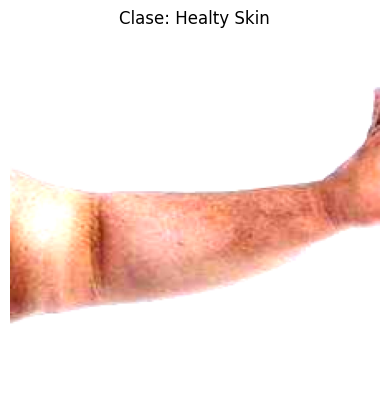

In [5]:
#Para ver una imagen del conjunto de datos
sample_image, sample_label = train_data[1200]  # Cambia el índice 0 por el índice de la imagen que deseas ver

# Convertir la imagen de Tensor a NumPy y reajustar las dimensiones si es necesario
sample_image = np.transpose(sample_image.numpy(), (1, 2, 0))  # (C x H x W) a (H x W x C)
# Normalizar los valores de los píxeles al rango [0, 1]
sample_image = sample_image / 2 + 0.5  # Deshacer la normalización (mean=0.5, std=0.5)

class_names = {
    0: "Acne",
    1: "Eczema",
    2: "Healty Skin",
    3: "Melanoma",
    # Agrega el resto de nombres de clase según corresponda...
}
# Obtener el nombre de la clase correspondiente al índice sample_label
sample_class_name = class_names[sample_label]

# Mostrar la imagen utilizando matplotlib
plt.imshow(sample_image)
plt.title(f'Clase: {sample_class_name}')
plt.axis('off')  # Desactivar los ejes
plt.show()

In [6]:
model = models.resnet50(pretrained=True)

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Congelar los pesos de las capas preentrenadas
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la capa lineal final con una nueva capa para 3 clases
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

In [8]:
# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
#GPU selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:

train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader.dataset)
    test_losses.append(epoch_loss)
    
    accuracy = correct_preds / total_preds
    test_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.4f}')

In [81]:
#guardando los pesos del modelo
torch.save(model.state_dict(), 'model_weights_resnet50')

In [82]:
    # Fase de evaluación en el conjunto de datos de prueba
    model.eval()  # Establecer el modelo en modo de evaluación
    correct_preds = 0
    total_preds = 0

    all_preds = []
    true_labels = []
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes durante la evaluación
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)  # Propagación hacia adelante
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

            #relleno de matriz de confusion
            all_preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy()) 
    # Calcular la precisión en el conjunto de datos de prueba
    accuracy = correct_preds / total_preds
    
    # Imprimir la precisión en el conjunto de datos de prueba
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.4f}')

Epoch [10/10], Test Accuracy: 0.9147


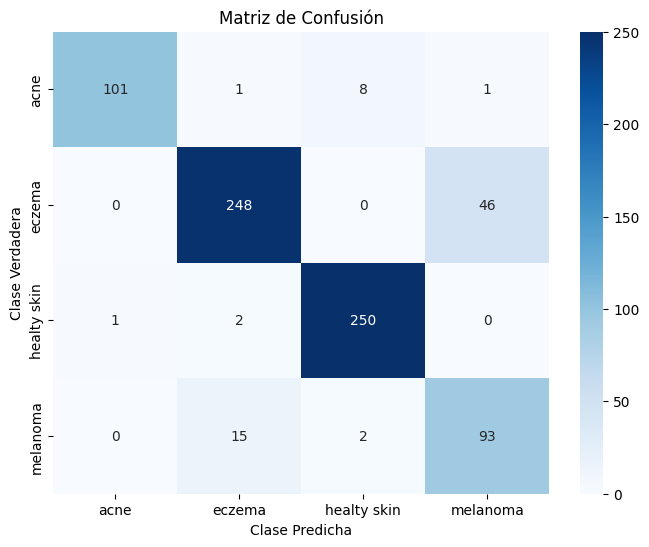

In [14]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, all_preds)

# Visualizar la matriz de confusión
name_class= ["acne", "eczema", "healty skin", "melanoma"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=name_class, yticklabels=name_class)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

In [16]:
#funcion para clasificar imagenes
def classify_image(image_path):
    model.eval()
    image = Image.open(image_path)
    input_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
    probabilities = torch.softmax(output, dim=1).squeeze().numpy()
    return probabilities

In [17]:
# Function para visualizar predicted probabilities
def visualize_probabilities(probabilities):
    class_names = ['Acne', 'Eczema', 'Healty Skin','Melanoma']
    for i, prob in enumerate(probabilities):
        print(f'{class_names[i]}: {prob*100:.2f}%')

In [61]:
# Clasificando imagen
image_path = 'C:/Users/asus/Documents/Archivos/Fusemachines microdegree/Proyecto final/Data/Eczema.jpg'  # Replace 'your_image.jpg' with the path to your image
probabilities = classify_image(image_path)
visualize_probabilities(probabilities)

Acne: 0.23%
Eczema: 93.86%
Healty Skin: 4.80%
Melanoma: 1.11%


NOTAS IMPORTANTES:

Cuando suministro una imagen para clasificar melanoma estamos teniendo problemas debido a que si se toma muy lejos la foto pareceria que no lo hace bien
